In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer,Input, Dense,LSTM, Dropout, Activation, Concatenate, Flatten, BatchNormalization, Conv1D, MaxPooling1D,Lambda,multiply,Permute,Reshape,RepeatVector
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

print('Tensorflow version:', tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
#print('Data Availabe for:\n', os.listdir('data/15tf/15tf_fasta_1000_offset_pos'))
print('Models Availabe for:\n', os.listdir('checkpoints'))
#print('Subset data Availabe for:\n', os.listdir('data_subset'))

# Recreate the exact same model, including its weights and the optimizer
# model = tf.keras.models.load_model('train_models/checkpoints/model_checkpoint_MYC.h5')
# Show the model architecture
# model.summary()

Tensorflow version: 2.9.1
Num GPUs Available:  0
Models Availabe for:
 ['model_checkpoint_base_JUN.h5', 'model_checkpoint_GC_JUN.h5', 'model_checkpoint_base_CTCF.h5', 'model_checkpoint_GC_MAX.h5', 'model_checkpoint_base_CEBPB.h5', 'model_checkpoint_GC_CEBPB.h5', 'model_checkpoint_GC_CTCF.h5', 'model_checkpoint_base_REST.h5', 'model_checkpoint_CB_MYC.h5', 'model_checkpoint_CB_JUN.h5', 'model_checkpoint_base_FOSL2.h5', 'model_checkpoint_CB_MAX.h5', 'model_checkpoint_CB_CEBPB.h5', 'model_checkpoint_GC_JUNB.h5', 'model_checkpoint_CB_JUNB.h5', 'model_checkpoint_GC_MYC.h5', 'model_checkpoint_base_MYC.h5', 'model_checkpoint_GC_REST.h5', 'model_checkpoint_base_MAX.h5', 'model_checkpoint_base_JUNB.h5', 'model_checkpoint_CB_REST.h5', 'model_checkpoint_CB_FOSL2.h5', 'model_checkpoint_CB_CTCF.h5', 'model_checkpoint_GC_FOSL2.h5']


2022-06-14 15:38:58.252488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 15:38:58.252650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-14 15:38:58.252766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-14 15:38:58.252882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-06-14 15:38:58.252995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [4]:
import pandas as pd
import os
import numpy as np
# Validation
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import r2_score

tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST','CTCF', 'FOSL2','JUN']
#tfs = ['CEBPB', 'MAX']
cross_model_roc = pd.DataFrame(index=tfs, columns=tfs)
cross_model_mcc = pd.DataFrame(index=tfs, columns=tfs)
cross_model_kappa = pd.DataFrame(index=tfs, columns=tfs)
cross_model_pr = pd.DataFrame(index=tfs, columns=tfs)

mode = 'GC'
#for saved_model in os.listdir('checkpoints'):
for TF1 in tfs:
    model = tf.keras.models.load_model('checkpoints/model_checkpoint_'+mode+'_'+TF1+'.h5')
    #print(saved_model)
    for TF in tfs:
        x=np.load('/mnt/media/tfbind3/training_v5_'+mode+'/'+'x1_val_'+TF+'.npy')
        y=np.load('/mnt/media/tfbind3/training_v5_'+mode+'/'+'y_val_'+TF+'.npy')
        print(TF, x.shape)

        y_pred = model.predict([x]).flatten() ###classification
        y_act = y
        y_mod = np.where(y_pred>0.5,1,0)

        ###
        try:
            roc_auc_score_ = roc_auc_score(y_act, y_pred, average=None).tolist()
        except:
            roc_auc_score_ = 0.5
        #fpr, tpr,_ = roc_curve(y_act, y_mod)

        #precision, recall, _ = precision_recall_curve(y_act, y_mod)
        average_precision_score_ = average_precision_score(y_act, y_pred, average=None).tolist()
        mcc = matthews_corrcoef(y_act, y_mod)
        kappa = cohen_kappa_score(y_act, y_mod)
        
        cross_model_roc[TF][TF1]=roc_auc_score_
        cross_model_mcc[TF][TF1]=mcc
        cross_model_kappa[TF][TF1]=kappa
        cross_model_pr[TF][TF1]=average_precision_score_
        print(TF, TF1, '- roc', roc_auc_score_, '-pr', average_precision_score_)
    del model

# Print
print(mode)
import time
cross_model_pr.to_csv('220518_results/cross_model_pr_'+mode+'.csv')
cross_model_roc.to_csv('220518_results/cross_model_roc_'+mode+'.csv')
cross_model_mcc.to_csv('220518_results/cross_model_mcc_'+mode+'.csv')
cross_model_kappa.to_csv('220518_results/cross_model_kappa_'+mode+'.csv')

/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)
CEBPB CEBPB - roc 0.9993473209972776 -pr 0.9990500690051347
MAX (13542, 1000, 4)
MAX CEBPB - roc 0.42541493611907577 -pr 0.1989418208143155
MYC (8267, 1000, 4)
MYC CEBPB - roc 0.4677414808760112 -pr 0.23405950533210698
JUNB (21498, 1000, 4)
JUNB CEBPB - roc 0.5725765142573286 -pr 0.5624918166241293
REST (10417, 1000, 4)
REST CEBPB - roc 0.33966939392915796 -pr 0.28667175885209584
CTCF (41113, 1000, 4)
CTCF CEBPB - roc 0.40038168475168473 -pr 0.35926107337906893
FOSL2 (34556, 1000, 4)
FOSL2 CEBPB - roc 0.555328146475446 -pr 0.5342720452287762
JUN (23887, 1000, 4)
JUN CEBPB - roc 0.5663311410807013 -pr 0.5311706135447873


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)
CEBPB MAX - roc 0.553026872832261 -pr 0.5179981026574977
MAX (13542, 1000, 4)
MAX MAX - roc 0.9973359659066395 -pr 0.9833171044958968
MYC (8267, 1000, 4)
MYC MAX - roc 0.9718835029809152 -pr 0.884647011388108
JUNB (21498, 1000, 4)
JUNB MAX - roc 0.6267329959138502 -pr 0.5833715759824956
REST (10417, 1000, 4)
REST MAX - roc 0.6097300524295487 -pr 0.4668700420639166
CTCF (41113, 1000, 4)
CTCF MAX - roc 0.7529279920654987 -pr 0.6865862187296672
FOSL2 (34556, 1000, 4)
FOSL2 MAX - roc 0.6257802360360292 -pr 0.5769717094905195
JUN (23887, 1000, 4)
JUN MAX - roc 0.6245368113553404 -pr 0.562462649568292


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)
CEBPB MYC - roc 0.5651382110963494 -pr 0.5324834435055006
MAX (13542, 1000, 4)
MAX MYC - roc 0.9705818758408611 -pr 0.895553725357179
MYC (8267, 1000, 4)
MYC MYC - roc 0.9941902451087881 -pr 0.9741368544444436
JUNB (21498, 1000, 4)
JUNB MYC - roc 0.6785060475182634 -pr 0.6365637104034775
REST (10417, 1000, 4)
REST MYC - roc 0.6268566419908346 -pr 0.482539532175999
CTCF (41113, 1000, 4)
CTCF MYC - roc 0.7203247472866533 -pr 0.6319365557176087
FOSL2 (34556, 1000, 4)
FOSL2 MYC - roc 0.6832766413814014 -pr 0.6346286142992701
JUN (23887, 1000, 4)
JUN MYC - roc 0.6763282885110115 -pr 0.6130405864120304


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


CEBPB JUNB - roc 0.5 -pr 0.492563169747816
MAX (13542, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MAX JUNB - roc 0.5 -pr 0.2315758381332152
MYC (8267, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MYC JUNB - roc 0.5 -pr 0.24265150598766178
JUNB (21498, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


JUNB JUNB - roc 0.5 -pr 0.4891617824913945
REST (10417, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


REST JUNB - roc 0.5 -pr 0.3738120380147835
CTCF (41113, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


CTCF JUNB - roc 0.5 -pr 0.4166808552039501
FOSL2 (34556, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


FOSL2 JUNB - roc 0.5 -pr 0.4819423544391712
JUN (23887, 1000, 4)


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


JUN JUNB - roc 0.5 -pr 0.46573449993720434
CEBPB (40407, 1000, 4)
CEBPB REST - roc 0.5265780561768275 -pr 0.5048667766229762
MAX (13542, 1000, 4)
MAX REST - roc 0.707470710211338 -pr 0.38689155082123733
MYC (8267, 1000, 4)
MYC REST - roc 0.6950229808896262 -pr 0.39781776943724845
JUNB (21498, 1000, 4)
JUNB REST - roc 0.5374681547778415 -pr 0.5137563241999179
REST (10417, 1000, 4)
REST REST - roc 0.9997672492443278 -pr 0.9995663589168552
CTCF (41113, 1000, 4)
CTCF REST - roc 0.7381502479280997 -pr 0.6277876501959041
FOSL2 (34556, 1000, 4)
FOSL2 REST - roc 0.5404482918133858 -pr 0.5063555339006481
JUN (23887, 1000, 4)
JUN REST - roc 0.5408770172686117 -pr 0.49181809477492505


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)
CEBPB CTCF - roc 0.5459572910276957 -pr 0.5245521358675166
MAX (13542, 1000, 4)
MAX CTCF - roc 0.6794448791072262 -pr 0.4862321334915193
MYC (8267, 1000, 4)
MYC CTCF - roc 0.6523403754556487 -pr 0.4369385054012508
JUNB (21498, 1000, 4)
JUNB CTCF - roc 0.5412346833460806 -pr 0.5139669043229579
REST (10417, 1000, 4)
REST CTCF - roc 0.6147214577378248 -pr 0.5011078761998482
CTCF (41113, 1000, 4)
CTCF CTCF - roc 0.998959010717965 -pr 0.9981199075558367
FOSL2 (34556, 1000, 4)
FOSL2 CTCF - roc 0.5378297275787716 -pr 0.5102711932732809
JUN (23887, 1000, 4)
JUN CTCF - roc 0.5291830064323686 -pr 0.4892337173668482


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)
CEBPB FOSL2 - roc 0.5923763747640747 -pr 0.5748692697424683
MAX (13542, 1000, 4)
MAX FOSL2 - roc 0.5154284211522395 -pr 0.2640359621054602
MYC (8267, 1000, 4)
MYC FOSL2 - roc 0.5635726584819889 -pr 0.3250252763908231
JUNB (21498, 1000, 4)
JUNB FOSL2 - roc 0.9984777252988205 -pr 0.9977374962178245
REST (10417, 1000, 4)
REST FOSL2 - roc 0.47111928074662285 -pr 0.3622919049473192
CTCF (41113, 1000, 4)
CTCF FOSL2 - roc 0.4147950958451652 -pr 0.36726652020509226
FOSL2 (34556, 1000, 4)
FOSL2 FOSL2 - roc 0.9991416814953871 -pr 0.9987050271829412
JUN (23887, 1000, 4)
JUN FOSL2 - roc 0.9975136122160417 -pr 0.995948832760398


/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


CEBPB (40407, 1000, 4)
CEBPB JUN - roc 0.5511350048711671 -pr 0.544296178961535
MAX (13542, 1000, 4)
MAX JUN - roc 0.462073627680459 -pr 0.23214101698394773
MYC (8267, 1000, 4)
MYC JUN - roc 0.4964656023942229 -pr 0.27253928110500014
JUNB (21498, 1000, 4)
JUNB JUN - roc 0.9980793634509224 -pr 0.9972633763555971
REST (10417, 1000, 4)
REST JUN - roc 0.44280447416872115 -pr 0.3425964130238304
CTCF (41113, 1000, 4)
CTCF JUN - roc 0.40741994945998383 -pr 0.36251983883225086
FOSL2 (34556, 1000, 4)
FOSL2 JUN - roc 0.9979639089443872 -pr 0.9973383906523391
JUN (23887, 1000, 4)
JUN JUN - roc 0.9991580165132091 -pr 0.9982042720175412
GC


In [27]:
# # Load cross model performances
# import os 
# for f in os.listdir('results/'):
#     if f.startswith('20220514'):a
#         print(f)
# cross_model_pr = pd.read_csv('results/20220514-192846_cross_model_pr_base.csv', index_col=0)
# cross_model_roc= pd.read_csv('results/20220514-192846_cross_model_roc_base.csv', index_col=0)
# cross_model_mcc = pd.read_csv('results/20220514-192846_cross_model_mcc_base.csv', index_col=0)
# cross_model_kappa = pd.read_csv('results/20220514-192846_cross_model_kappa_base.csv', index_col=0)

20220514-192846_cross_model_kappa_base.csv
20220514-192846_cross_model_mcc_base.csv
20220514-192846_cross_model_roc_base.csv
20220514-190355_saliency_dict_ones_base.npy
20220514-190356_saliency_dict_zero_base.npy
20220514-192846_cross_model_pr_base.csv


In [5]:
# Validation
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn import metrics
from sklearn.metrics import r2_score
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

mode = 'base'
TF = 'CEBPB'

tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST','CTCF', 'FOSL2','JUN']
stats_df = pd.DataFrame(columns=['roc', 'pr', 'mcc', 'kappa'], index=tfs)
for TF in tfs:
    model = tf.keras.models.load_model('checkpoints/model_checkpoint_'+mode+'_'+TF+'.h5')
    x = np.load('/mnt/media/tfbind3/training_v5_'+mode+'/'+'x1_val_'+TF+'.npy')
    y = np.load('/mnt/media/tfbind3/training_v5_'+mode+'/'+'y_val_'+TF+'.npy')

    ##### predictions
    y_pred = model.predict([x]).flatten() ###classification
    y_act = y
    y_mod = np.where(y_pred>0.5,1,0)

    roc_auc_score_ = roc_auc_score(y_act, y_pred, average=None).tolist()
    fpr, tpr,_ = roc_curve(y_act, y_pred, pos_label=1)
    average_precision_score_ = average_precision_score(y_act, y_pred, average=None).tolist()
    mcc = matthews_corrcoef(y_act, y_mod)
    kappa = cohen_kappa_score(y_act, y_mod)

    stats_df['roc'][TF]=roc_auc_score_
    stats_df['pr'][TF]=average_precision_score_
    stats_df['mcc'][TF]=mcc
    stats_df['kappa'][TF]=kappa

    del model

stats_df.to_csv('220518_results/performance_stats_%s.csv'%(mode))

/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)
/home/dell15/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: functions is not loaded, but a Lambda layer uses 

In [19]:
# Data statistics
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import collections
tfs = ['CEBPB', 'MAX', 'MYC', 'JUNB', 'REST','CTCF', 'FOSL2','JUN']
sets = ['train_0', 'train_1', 'test_0', 'test_1', 'val_0', 'val_1']
mode = 'CB'
stats_data = pd.DataFrame(columns=sets, index=tfs)
for set in tqdm(sets):
    for TF in tfs:
        y = np.load('/mnt/media/tfbind3/training_v5_'+mode+'/'+'y_%s_'%(set.split('_')[0])+TF+'.npy')
        if set.endswith('0'):
            stats_data[set][TF]=collections.Counter(y)[0]
        if set.endswith('1'):
            stats_data[set][TF]=collections.Counter(y)[1]
        # print(TF, set, collections.Counter(y))

stats_data.to_csv('results/stats_data_%s.csv'%(mode))

100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


In [20]:
stats_data

,train_0,train_1,test_0,test_1,val_0,val_1
CEBPB,167634,167500,20927,20965,20898,20994
MAX,167220,167271,20932,20879,20905,20907
MYC,101875,101627,12554,12884,12760,12678
JUNB,162143,162202,20345,20198,20228,20316
REST,123230,123098,15423,15368,15302,15489
CTCF,179357,179278,22374,22455,22416,22414
FOSL2,164380,164724,20691,20447,20619,20519
JUN,163204,163160,20469,20327,20305,20491


==Performance Metrics==
--------------------
ROC_AUC 0.9703151317066452
PR_AUC 0.971932002514446
MCC 0.8346901620851059
KAPPA 0.834595793470293

==Confusion Matrix==
[[387  30]
 [ 36 347]]


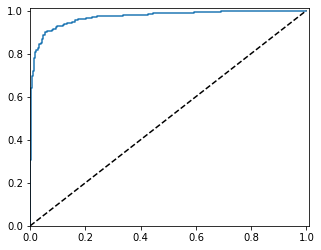

In [31]:
###
roc_auc_score_ = roc_auc_score(y_act, y_pred, average=None).tolist()
fpr, tpr,_ = roc_curve(y_act, y_pred, pos_label=1)
average_precision_score_ = average_precision_score(y_act, y_pred, average=None).tolist()
mcc = matthews_corrcoef(y_act, y_mod)
kappa = cohen_kappa_score(y_act, y_mod)

fig, ax = plt.subplots(1, figsize=(5,4))
ax.plot(fpr, tpr, alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])


print('==Performance Metrics==')
print('--------------------')
print('ROC_AUC', roc_auc_score_)
print('PR_AUC', average_precision_score_)
print('MCC', mcc)
print('KAPPA', kappa)
print('\n==Confusion Matrix==')
print(confusion_matrix(y_act, y_mod))

In [13]:
y_act, y_mod

(array([1, 0, 1, ..., 1, 0, 0]), array([1, 1, 1, ..., 1, 1, 1]))

In [10]:
import collections
collections.Counter(y_act)

Counter({1: 67427, 0: 67199})